In [97]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import constants as cs
import Dates as dates 
import payoff as pf
import GBM as gbm

%reload_ext autoreload
%autoreload 2



In [98]:


def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()

data




[*********************100%***********************]  2 of 2 completed


Ticker,LONN.SW,SIKA.SW
Date,,
2023-04-27,542.120483,237.429871
2023-04-28,546.263367,242.368103
2023-05-02,545.868896,239.800232
2023-05-03,574.079590,241.479218
2023-05-04,572.895935,242.071823
...,...,...
2024-07-24,522.599976,262.000000
2024-07-25,559.799988,258.500000
2024-07-26,581.000000,262.000000


In [99]:
params_product = {
    'Denomination': 1000,
    'Coupon_Rate': (0.08 / 4) ,  # Quarterly coupon payments
}

In [100]:
Tlist = dates.num_business_days(cs.initial_fixing_date, cs.final_fixing_date)
present_value_list = []
indexlist = []

In [105]:
import warnings
warnings.filterwarnings("ignore")
date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
date_list = pd.Series(date_list)
date_list = date_list.head(60).tolist()

T = date_list
present_value_list = []
for fdos in T:  
    print(f"Processing FDOS: {fdos}")
    # Run the simulation
    sim_T = gbm.multi_asset_gbm_n_sims(plot=False, plotasset=False, nsims=cs.n_sims, data=data, fdos=fdos)
    # Extract asset paths
    lonza_path = sim_T['LONN.SW']
    sika_path = sim_T['SIKA.SW']
    # Calculate payoffs
    payoff_T = pf.payoff(lonza_path, sika_path, params_product, fdos)
    # Compute expected payoff
    expected_payoff = np.mean(payoff_T)
    # Discount to present value (assuming present value as of fdos)
    r = cs.interest_rate  # Use the same interest rate as in the simulation
    T_discount = dates.num_business_days(fdos, cs.final_fixing_date) / 252  # Time in years
    present_value = expected_payoff * np.exp(-(r) * T_discount)
    # Store the present value
    present_value_list.append(present_value)



Processing FDOS: 2023-04-27 00:00:00
Length of date_list: 315
Number of time steps (num_steps): 315
Processing FDOS: 2023-04-28 00:00:00
Length of date_list: 314
Number of time steps (num_steps): 314
Processing FDOS: 2023-05-02 00:00:00
Length of date_list: 313
Number of time steps (num_steps): 313
Processing FDOS: 2023-05-03 00:00:00
Length of date_list: 312
Number of time steps (num_steps): 312
Processing FDOS: 2023-05-04 00:00:00
Length of date_list: 311
Number of time steps (num_steps): 311
Processing FDOS: 2023-05-05 00:00:00
Length of date_list: 310
Number of time steps (num_steps): 310
Processing FDOS: 2023-05-08 00:00:00
Length of date_list: 309
Number of time steps (num_steps): 309
Processing FDOS: 2023-05-09 00:00:00
Length of date_list: 308
Number of time steps (num_steps): 308
Processing FDOS: 2023-05-10 00:00:00
Length of date_list: 307
Number of time steps (num_steps): 307
Processing FDOS: 2023-05-11 00:00:00
Length of date_list: 306
Number of time steps (num_steps): 306


<Axes: xlabel='date'>

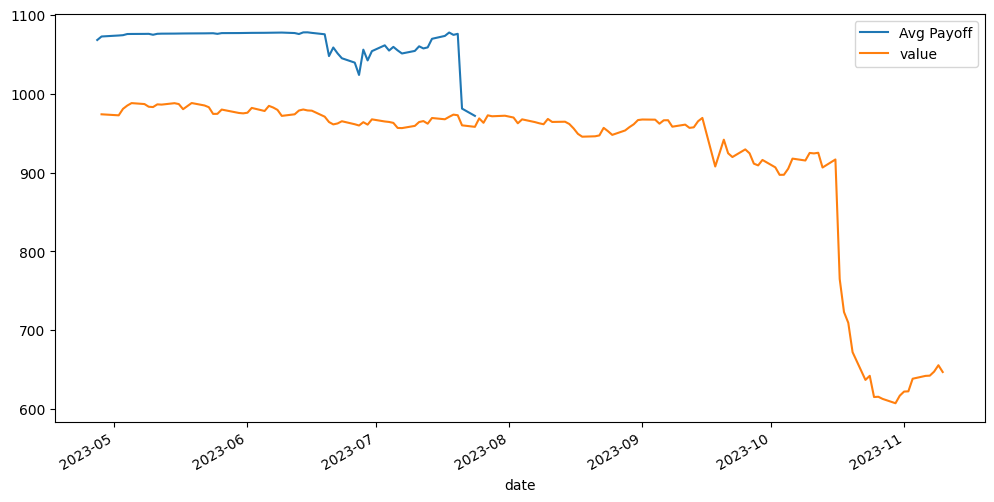

In [106]:
fig, ax = plt.subplots(figsize=(12, 6))
present_value_df = pd.DataFrame({'Avg Payoff': present_value_list}, index=T)
present_value_df.plot(ax = ax)
import json 
productprice = pd.read_json(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\product_price.json')
productprice.index = productprice['date']
productprice = productprice[['value']].sort_index()
productprice = productprice * 10
productprice.plot(ax =ax)

In [107]:
def calculate_rmse(df1, df2):
 
    # Ensure the DataFrames have the same shape
    assert df1.shape == df2.shape, "DataFrames must have the same shape"
    
    # Calculate the squared differences
    squared_diff = (df1 - df2) ** 2
    
    # Calculate the mean of the squared differences
    mean_squared_diff = squared_diff.mean().mean()
    
    # Calculate the root mean square error
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

# Example usage


In [108]:
productprice = productprice[: pd.Timestamp('2023-07-24 00:00:00')]
(present_value_df[1:]- productprice)

,Avg Payoff,value
2023-04-28,NaN,NaN
2023-05-02,NaN,NaN
2023-05-03,NaN,NaN
2023-05-04,NaN,NaN
2023-05-05,NaN,NaN
2023-05-08,NaN,NaN
2023-05-09,NaN,NaN
2023-05-10,NaN,NaN
2023-05-11,NaN,NaN
2023-05-12,NaN,NaN
